# Pipeline ML : Données de Marché → Features → Modèle Prédictif

Ce notebook présente le pipeline complet de machine learning pour la prédiction de direction des prix de marché.

**Objectif** : Démontrer comment transformer des données massives de marché en un modèle prédictif performant en utilisant Polars pour le feature engineering et XGBoost pour la prédiction.

**Narrative** : Massive data → Polars pipeline → predictive model


In [5]:
# Imports
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import roc_auc_score

from src.config import config
from src.data.storage import load_dataframe, save_dataframe, find_latest_data_file
from src.features.engineering import compute_all_features
from src.features.targets import generate_targets
from src.ml.training import prepare_dataset, train_model
from src.ml.evaluation import evaluate_model, plot_feature_importance

# Configuration matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


## 1. Chargement des données

Nous commençons par charger le dataset ML préparé. Si le fichier `ml_dataset.parquet` n'existe pas, nous le créons en combinant les données brutes et en appliquant le feature engineering.


In [6]:
ml_dataset_path = config.PROCESSED_DATA_DIR / "ml_dataset.parquet"

if ml_dataset_path.exists():
    print(f"Chargement du dataset existant: {ml_dataset_path}")
    df = pl.read_parquet(ml_dataset_path)
else:
    print("Dataset ML non trouvé. Création depuis les données brutes...")
    
    symbols = config.DEFAULT_SYMBOLS
    interval = config.DEFAULT_INTERVAL
    
    from src.data.ingestion import normalize_datetime_column
    
    features_dict = {}
    for symbol in symbols:
        data_file = find_latest_data_file(symbol, interval)
        if data_file:
            print(f"Chargement {symbol} depuis {data_file.name}")
            df_raw = load_dataframe(data_file)
            
            df_raw = normalize_datetime_column(df_raw, target_name="datetime")
            
            if 'datetime' in df_raw.columns:
                df_raw = df_raw.with_columns(
                    pl.col('datetime').cast(pl.Datetime('ns')).alias('datetime')
                )
            
            df_features = compute_all_features(
                df_raw,
                datetime_col="datetime",
                momentum_periods=config.MOMENTUM_PERIODS,
                volatility_windows=config.VOLATILITY_WINDOWS,
            )
            
            df_features = generate_targets(
                df_features,
                horizon=config.PREDICTION_HORIZON,
                target_type=config.TARGET_TYPE,
                datetime_col="datetime",
            )
            
            features_dict[symbol] = df_features
    
    if not features_dict:
        raise ValueError("Aucune donnée brute trouvée. Exécutez d'abord le pipeline d'ingestion.")
    
    # Ensure all DataFrames have columns in the same order and same types
    first_df = next(iter(features_dict.values()))
    column_order = first_df.columns
    schema = first_df.schema
    
    normalized_dfs = []
    for symbol, df_feat in features_dict.items():
        df_reordered = df_feat.select(column_order)
        
        cast_expressions = []
        for col_name in column_order:
            expected_dtype = schema[col_name]
            actual_dtype = df_reordered[col_name].dtype
            
            if actual_dtype != expected_dtype:
                # Normalize datetime to match the first DataFrame's type
                if isinstance(actual_dtype, pl.Datetime) and isinstance(expected_dtype, pl.Datetime):
                    cast_expressions.append(pl.col(col_name).cast(expected_dtype).alias(col_name))
                elif actual_dtype != expected_dtype:
                    cast_expressions.append(pl.col(col_name).cast(expected_dtype).alias(col_name))
        
        if cast_expressions:
            df_reordered = df_reordered.with_columns(cast_expressions)
        
        normalized_dfs.append(df_reordered)
    
    df = pl.concat(normalized_dfs)
    
    save_dataframe(df, ml_dataset_path)
    print(f"Dataset ML créé et sauvegardé: {ml_dataset_path}")

print(f"\nDataset chargé: {df.height:,} lignes, {len(df.columns)} colonnes")
print(f"Colonnes: {', '.join(df.columns[:10])}...")


Dataset ML non trouvé. Création depuis les données brutes...
Chargement AAPL depuis AAPL_1min_20251113_100513.parquet
Chargement MSFT depuis MSFT_1min_20251113_100527.parquet
Chargement TSLA depuis TSLA_1min_20251113_100539.parquet
Chargement GOOG depuis GOOG_1min_20251113_103038.parquet
Chargement AMZN depuis AMZN_1min_20251113_103050.parquet
Dataset ML créé et sauvegardé: /Users/erwinrodrigues/project/quant/MarketDataPipeline/data/processed/ml_dataset.parquet

Dataset chargé: 495 lignes, 56 colonnes
Colonnes: open, high, low, close, volume, datetime, rsi, macd, macd_signal, macd_histogram...


## 2. Exploration et visualisation des features

Visualisons quelques features clés pour comprendre les données avant l'entraînement.


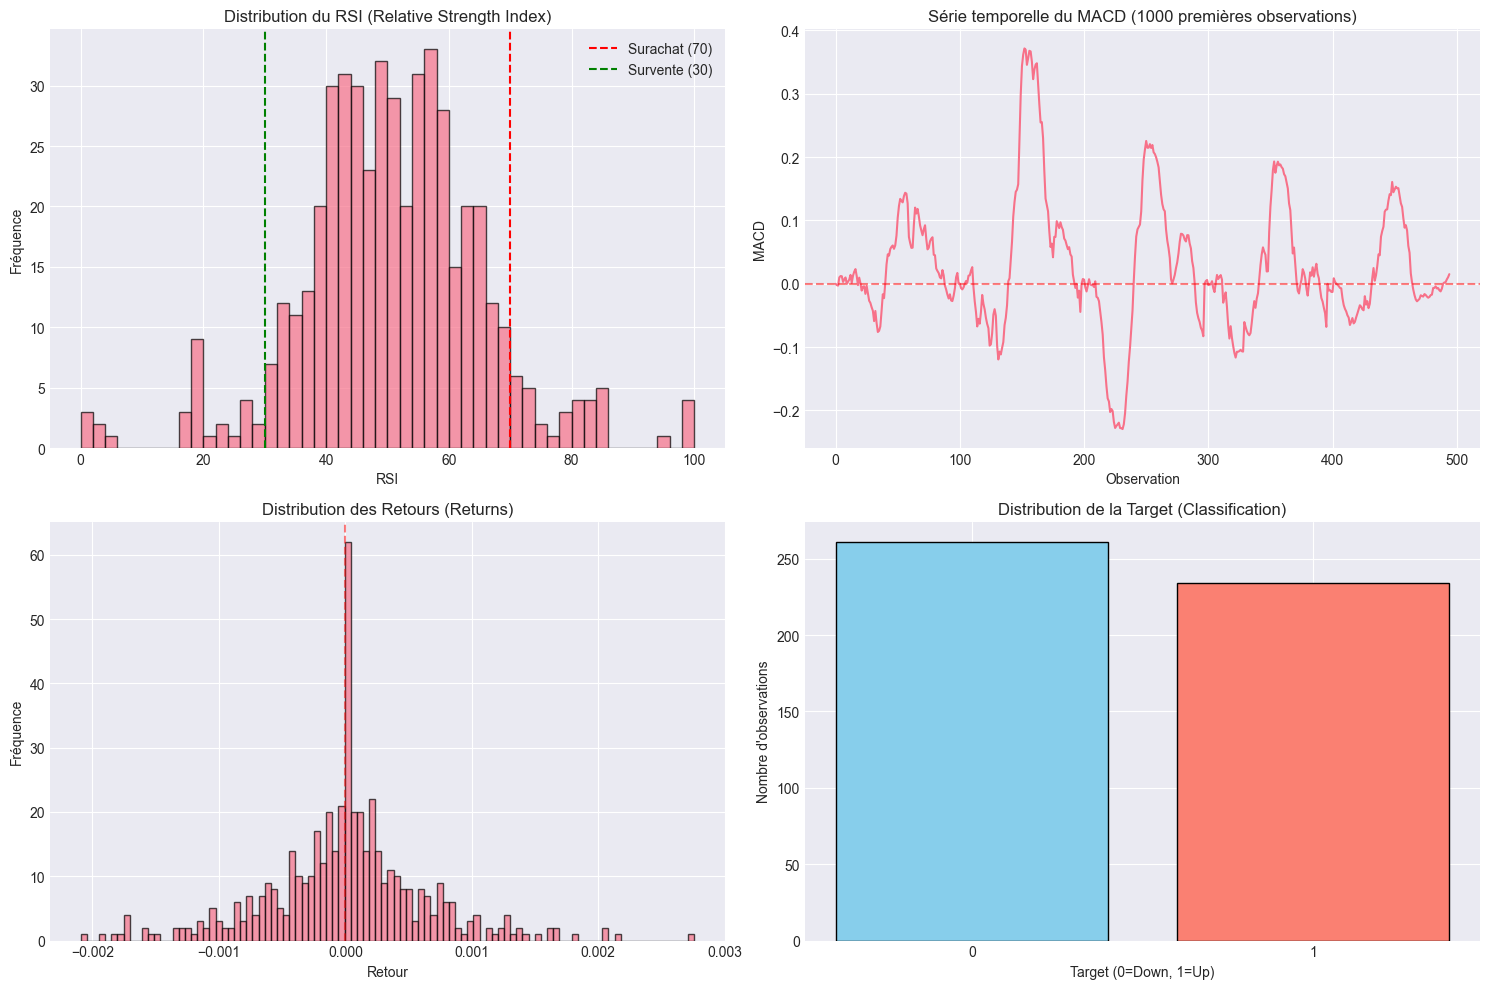


Statistiques descriptives des features clés:

RSI: 50.81 ± 14.77
Returns: 0.000003 ± 0.000634
Target (proportion de Up): 47.27%


In [7]:
features_to_plot = ['rsi', 'macd', 'returns']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution du RSI
if 'rsi' in df.columns:
    df_rsi = df.select(['rsi']).drop_nulls()
    if df_rsi.height > 0:
        axes[0, 0].hist(df_rsi['rsi'].to_numpy(), bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('Distribution du RSI (Relative Strength Index)')
        axes[0, 0].set_xlabel('RSI')
        axes[0, 0].set_ylabel('Fréquence')
        axes[0, 0].axvline(70, color='r', linestyle='--', label='Surachat (70)')
        axes[0, 0].axvline(30, color='g', linestyle='--', label='Survente (30)')
        axes[0, 0].legend()

# 2. Série temporelle du MACD
if 'macd' in df.columns:
    df_macd = df.select(['datetime', 'macd']).drop_nulls().head(1000)  # Limiter pour la visualisation
    if df_macd.height > 0:
        axes[0, 1].plot(df_macd['macd'].to_numpy())
        axes[0, 1].set_title('Série temporelle du MACD (1000 premières observations)')
        axes[0, 1].set_xlabel('Observation')
        axes[0, 1].set_ylabel('MACD')
        axes[0, 1].axhline(0, color='r', linestyle='--', alpha=0.5)

# 3. Distribution des retours
if 'returns' in df.columns:
    df_returns = df.select(['returns']).drop_nulls()
    if df_returns.height > 0:
        returns_data = df_returns['returns'].to_numpy()
        axes[1, 0].hist(returns_data, bins=100, edgecolor='black', alpha=0.7)
        axes[1, 0].set_title('Distribution des Retours (Returns)')
        axes[1, 0].set_xlabel('Retour')
        axes[1, 0].set_ylabel('Fréquence')
        axes[1, 0].axvline(0, color='r', linestyle='--', alpha=0.5)

# 4. Distribution de la target
if 'target' in df.columns:
    target_counts = df['target'].value_counts().sort('target')
    axes[1, 1].bar(target_counts['target'].to_list(), target_counts['count'].to_list(), 
                   color=['skyblue', 'salmon'], edgecolor='black')
    axes[1, 1].set_title('Distribution de la Target (Classification)')
    axes[1, 1].set_xlabel('Target (0=Down, 1=Up)')
    axes[1, 1].set_ylabel('Nombre d\'observations')
    axes[1, 1].set_xticks([0, 1])

plt.tight_layout()
plt.show()

# Statistiques descriptives
print("\nStatistiques descriptives des features clés:")
if 'rsi' in df.columns:
    print(f"\nRSI: {df['rsi'].mean():.2f} ± {df['rsi'].std():.2f}")
if 'returns' in df.columns:
    print(f"Returns: {df['returns'].mean():.6f} ± {df['returns'].std():.6f}")
if 'target' in df.columns:
    target_pct = df['target'].mean() * 100
    print(f"Target (proportion de Up): {target_pct:.2f}%")


## 3. Préparation du dataset pour l'entraînement

Nous préparons les données en séparant les features de la target et en créant les sets d'entraînement et de test.


In [8]:
X_train, X_test, y_train, y_test, feature_names = prepare_dataset(
    df,
    feature_columns=None,  # Use all features except target and datetime
    target_col="target",
    test_size=config.TEST_SIZE,
    random_state=config.RANDOM_STATE,
)

print(f"Dataset préparé:")
print(f"  Train: {X_train.shape[0]:,} échantillons, {X_train.shape[1]} features")
print(f"  Test:  {X_test.shape[0]:,} échantillons, {X_test.shape[1]} features")
print(f"\nNombre total de features: {len(feature_names)}")
print(f"Premières features: {', '.join(feature_names[:10])}...")


2025-11-13 11:06:06,849 - src.ml.training - INFO - Dataset préparé: 156 train, 39 test, 49 features


Dataset préparé:
  Train: 156 échantillons, 49 features
  Test:  39 échantillons, 49 features

Nombre total de features: 49
Premières features: rsi, macd, macd_signal, macd_histogram, bb_middle, bb_upper, bb_lower, bb_width, return_5, momentum_5...


## 4. Entraînement du modèle XGBoost

Nous entraînons un modèle XGBoost pour la classification binaire (prédiction de direction up/down).


In [9]:
hyperparameters = {
    "n_estimators": config.XGB_N_ESTIMATORS,
    "max_depth": config.XGB_MAX_DEPTH,
    "learning_rate": config.XGB_LEARNING_RATE,
    "subsample": config.XGB_SUBSAMPLE,
    "colsample_bytree": config.XGB_COLSAMPLE_BYTREE,
}

print("Hyperparamètres XGBoost:")
for key, value in hyperparameters.items():
    print(f"  {key}: {value}")

print("\nEntraînement du modèle en cours...")
start_time = time.time()

model = train_model(
    X_train,
    y_train,
    model_type=config.TARGET_TYPE,
    hyperparameters=hyperparameters,
    save_path=None,
)

training_time = time.time() - start_time
print(f"\nModèle entraîné avec succès en {training_time:.2f} secondes")


2025-11-13 11:06:12,538 - src.ml.training - INFO - Entraînement du modèle classification avec 156 échantillons...


Hyperparamètres XGBoost:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8

Entraînement du modèle en cours...


2025-11-13 11:06:14,511 - src.ml.training - INFO - Modèle entraîné avec succès



Modèle entraîné avec succès en 2.01 secondes


## 5. Évaluation du modèle

Nous évaluons les performances du modèle sur le set de test avec plusieurs métriques.


2025-11-13 11:06:19,609 - src.ml.evaluation - INFO - Métriques de classification:
2025-11-13 11:06:19,612 - src.ml.evaluation - INFO -   Accuracy: 0.5385
2025-11-13 11:06:19,613 - src.ml.evaluation - INFO -   Precision: 0.5161
2025-11-13 11:06:19,615 - src.ml.evaluation - INFO -   Recall: 0.8421
2025-11-13 11:06:19,617 - src.ml.evaluation - INFO -   F1-score: 0.6400
2025-11-13 11:06:19,621 - src.ml.evaluation - INFO - 
Classification Report:
2025-11-13 11:06:19,638 - src.ml.evaluation - INFO -               precision    recall  f1-score   support

           0       0.62      0.25      0.36        20
           1       0.52      0.84      0.64        19

    accuracy                           0.54        39
   macro avg       0.57      0.55      0.50        39
weighted avg       0.57      0.54      0.49        39




MÉTRIQUES D'ÉVALUATION
Accuracy:  0.5385
Precision: 0.5161
Recall:    0.8421
F1-Score:  0.6400
ROC-AUC:   0.6026


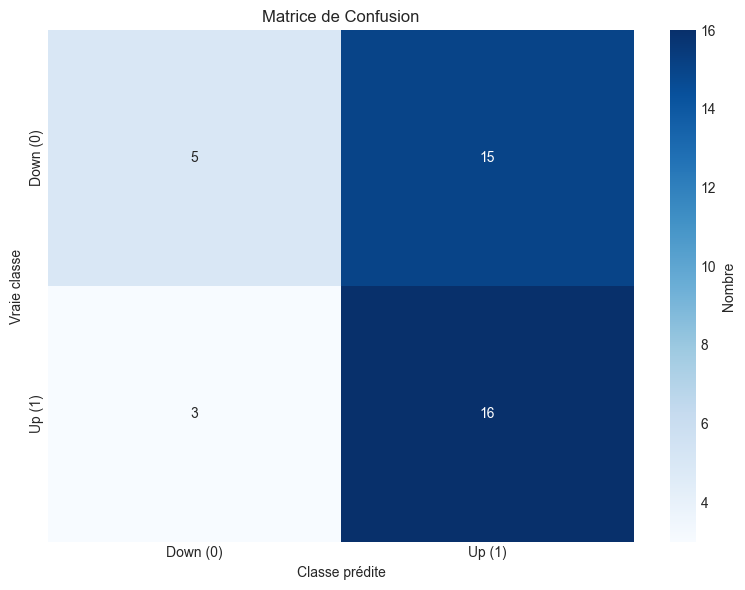

In [10]:
metrics = evaluate_model(
    model,
    X_test,
    y_test,
    model_type=config.TARGET_TYPE,
)

y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*60)
print("MÉTRIQUES D'ÉVALUATION")
print("="*60)
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1-Score:  {metrics['f1']:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*60)

# Afficher la matrice de confusion
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm, index=['Down (0)', 'Up (1)'], columns=['Down (0)', 'Up (1)'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Nombre'})
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.show()


## 6. Importance des features

Visualisons quelles features sont les plus importantes pour les prédictions du modèle.


/Users/erwinrodrigues/project/quant/MarketDataPipeline/src/ml/evaluation.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


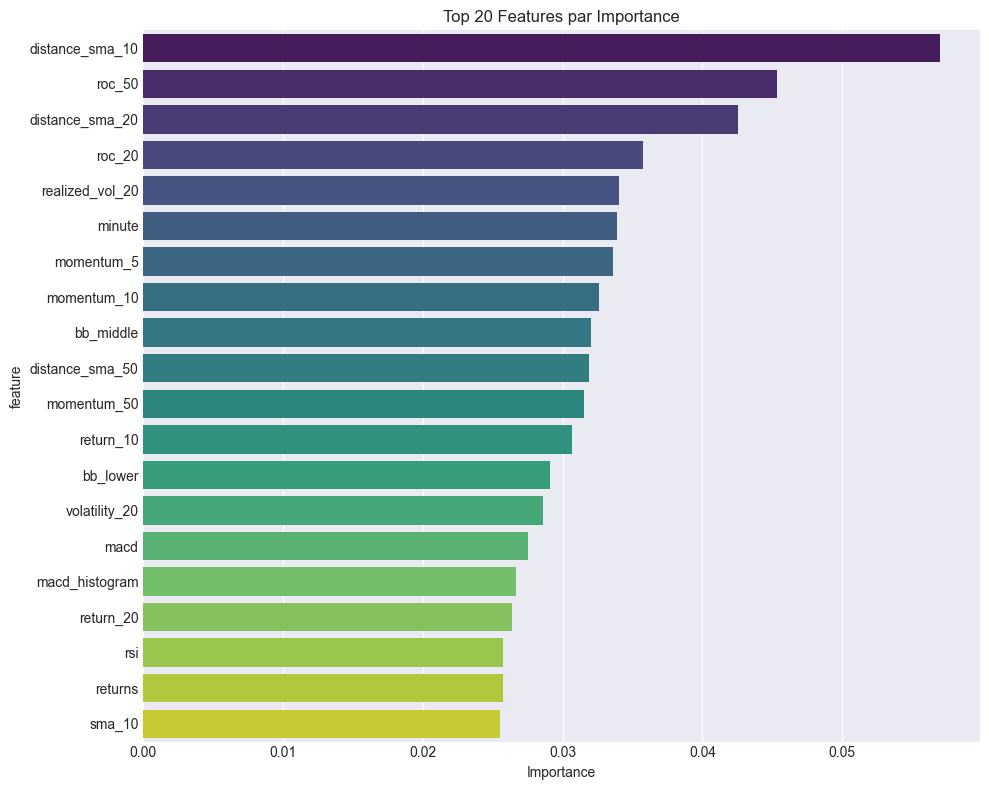

In [11]:
plot_feature_importance(
    model,
    feature_names,
    top_n=20,
    save_path=None,
)
